# Tensorflow Model Evaluation

The purpose of this notebook is to analyze the dense neural network (DNN) for the Health Insurance Cross Sell Prediction Project.
DNNs are "black boxes."  They work in mysterious ways.  It is often impossible to determine what effect each input variable will have, just from looking at the weights.  I used a "get_weights" function to extract the weights and did some manipulations, but the results were inconclusive.  They also changed a lot just by retraining the model.

For this reason, I have written a new notebook that evaluates the DNN for health insurance cross sell prediction by feeding controlled inputs, and analyzing the change in the output probabilities based on those inputs.

I used Region_Code_28 and Policy_Sales_Channel_26 as the defaults for every entry.  They were the most common ones present in the dataset, and the combination of the union of them represented almost 10% of all users.  Other variables were also set at a default value:

Vintage was set at 0.5 (it had been scaled to 0 - 1.0)
Annual_Premium was set at bin #6, the most common one

The remaining variables were set at a default value, but then varied in the experiment:
Gender - 1 (male)
Driving_License - 1
Previously_Insured - 0
Vehicle_Age_<1_year - 0
Vehicle_Age_>2_years - 0 (the value Vehicle_Age_<2 >1 year was omitted by the get_dummies function, so the default age was 1-2 years)
Vehicle_Damage_Yes - 1

Age was varied for all experiments



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tfmodel/tfModelInsurance.h5
/kaggle/input/health-insurance-cross-sell-prediction/train.csv
/kaggle/input/health-insurance-cross-sell-prediction/test.csv
/kaggle/input/health-insurance-cross-sell-prediction/sample_submission.csv


### First, the data is downloaded and processed into the dummies dataframe, the same way as it was in the other notebook.

In [2]:
train = pd.read_csv('../input/health-insurance-cross-sell-prediction/train.csv')
test = pd.read_csv('../input/health-insurance-cross-sell-prediction/test.csv')
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
train=pd.read_csv('../input/health-insurance-cross-sell-prediction/train.csv')
test=pd.read_csv('../input/health-insurance-cross-sell-prediction/test.csv')

train['Gender'] = train['Gender'].map( {'Female': 0, 'Male': 1} ).astype(int)
test['Gender'] = test['Gender'].map( {'Female': 0, 'Male': 1} ).astype(int)

for column in ['Region_Code','Policy_Sales_Channel']:
    train[column] = train[column].astype('int')
    test[column] = test[column].astype('int')
    
id=test.id  # capture id for later, test id only, for final submission
    
train=train.drop('id',axis=1) # drop the id column
test=test.drop('id',axis=1)

cat_feat = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage',
 'Region_Code', 'Policy_Sales_Channel']

for column in cat_feat:
    train[column] = train[column].astype('str')

for column in cat_feat:
    test[column] = test[column].astype('str')

train['Age'] = train['Age']//5 # divide all ages by 5 to get them into bins of 5 years each for the dummy variables
train['Age'] = train['Age'].astype(str)

test['Age'] = test['Age']//5
test['Age'] = test['Age'].astype(str)

train['Annual_Premium'] = ((train['Annual_Premium'])//1000)**0.5//1 #bin the annual premium into about 20 bins, with smaller bin sizes for smaller amounts
train['Annual_Premium'] = train['Annual_Premium'].astype(str)
test['Annual_Premium'] = ((test['Annual_Premium'])//1000)**0.5//1
test['Annual_Premium'] = test['Annual_Premium'].astype(str)

train=pd.get_dummies(train,drop_first=True)
test=pd.get_dummies(test,drop_first=True)

In [4]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

mm = MinMaxScaler()
train[['Vintage']] = mm.fit_transform(train[['Vintage']])
test[['Vintage']] = mm.fit_transform(test[['Vintage']])  # This simply reduces Vintage to smaller numbers.  They are not expected to make a difference to the model because the distribution is flat

rejectColumns = []
i = 0
for name in list(train.columns):
    if name not in list(test.columns):
        #print(name)
        rejectColumns.append(name)
#print(i)
print(rejectColumns)

rejectColumns.remove('Response')

for name in train.columns:
    #print(name)
    if name in rejectColumns:
        #print(name)
        train = train.drop(name,axis = 1)
        
i = 0
rejectColumns = []
for name in list(test.columns):
    if name not in list(train.columns):
        #print(name)
        rejectColumns.append(name)
        i += 1
        
for name in test.columns:
    #print(name)
    if name in rejectColumns:
        print(name)
        test = test.drop(name,axis = 1)
        

['Response', 'Annual_Premium_22.0', 'Annual_Premium_23.0', 'Policy_Sales_Channel_104', 'Policy_Sales_Channel_143', 'Policy_Sales_Channel_144', 'Policy_Sales_Channel_149', 'Policy_Sales_Channel_27', 'Policy_Sales_Channel_28', 'Policy_Sales_Channel_41', 'Policy_Sales_Channel_50', 'Policy_Sales_Channel_67', 'Policy_Sales_Channel_68', 'Policy_Sales_Channel_75', 'Policy_Sales_Channel_84']
Policy_Sales_Channel_141
Policy_Sales_Channel_142


In [5]:
from sklearn.model_selection import train_test_split
train_target=train['Response']
train=train.drop(['Response'], axis = 1)
x_train,x_test,y_train,y_test = train_test_split(train,train_target, random_state = 0)

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
# Deep Learning Libraries
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

2.3.0


In [7]:
model = tf.keras.models.load_model('../input/tfmodel/tfModelInsurance.h5')

In [8]:
# This is a useful function for finding duplicates
'''len(train.drop(train.drop_duplicates().index)) # 50386
traindups = train.drop(train.drop_duplicates().index) # first round
traindups = traindups.drop(traindups.drop_duplicates().index) # 2nd round, 16447, 3rd round, 6166; 4th, 2305; 5th, 844; 6th, 287; 7th, 84; 8th, 16
len(traindups) # 20103'''

'len(train.drop(train.drop_duplicates().index)) # 50386\ntraindups = train.drop(train.drop_duplicates().index) # first round\ntraindups = traindups.drop(traindups.drop_duplicates().index) # 2nd round, 16447, 3rd round, 6166; 4th, 2305; 5th, 844; 6th, 287; 7th, 84; 8th, 16\nlen(traindups) # 20103'

In [ ]:
# Region code 28 is by far the most common region
# Policy sales channel 26 is by far the most common
# the combination is 37,459 times.  The combination of region 28 and policy sales 124 is 27,546

In [9]:
model.get_weights() #6 / 234[24, 24, 24 ...], 24, 24[20, 20 ...], 20, 20[2, 2 ...], 2: [ 0.02806583, -0.02806598]

[array([[-0.08408733, -0.26128435,  0.05443826, ...,  0.03895455,
          0.0884156 ,  0.04023686],
        [ 0.0659532 , -0.04759106, -0.12669683, ...,  0.20125952,
          0.10127076,  0.00461927],
        [-0.10541607, -0.04364176,  0.1682666 , ..., -0.110099  ,
          0.06194175,  0.1155562 ],
        ...,
        [-0.02135529,  0.05836511,  0.03004203, ..., -0.123626  ,
          0.13304402, -0.00969951],
        [-0.14554112,  0.18773064,  0.35037297, ...,  0.08819072,
          0.21695486,  0.11834198],
        [-0.33040887, -0.10129929, -0.09473037, ..., -0.24883978,
          0.26661673,  0.15960819]], dtype=float32),
 array([ 0.04899568, -0.06973214, -0.08723961,  0.04314932,  0.04218549,
         0.10466924, -0.05546487,  0.04278205,  0.08427514,  0.10206162,
         0.07139275, -0.08033694,  0.00898732, -0.05603008,  0.08971817,
         0.05289615,  0.03036848, -0.09096061,  0.09851815,  0.07817233,
         0.05997772,  0.05476973,  0.03084891,  0.02908792], dtype

We have a complicated matrix of the following:
0: A 234 x 24 matrix of weights, multiplied by the first layer array (234) to output a second layer array (24) (it will become the first hidden layer, 24 neurons)
1: A 24 x 1 array of biases to add to the output of the multiplication from step 0.  This yields the final second layer (24), or first hidden layer
2: A 24 x 20 matrix of weights, yielding a third layer array (20) (second hidden layer, 20 neurons)
3: A 20 x 1 array of biases to add to the output of step 2.  This yields the final third layer, or second hidden layer
4: A 20 x 2 matrix of weights
5: A 2 x 1 array of biases

In [18]:
model.get_weights()[2][0] # series of weights for multiplying the first hidden layer to calculate the second hidden layer.

array([ 0.38729468,  0.21170412,  0.16193601, -0.10341428, -0.3258577 ,
        0.2695898 ,  0.03391992, -0.03119726, -0.20141716, -0.26379022,
       -0.29237506,  0.18922813,  0.15801242,  0.3984717 ,  0.14033063,
       -0.13422887,  0.15181413,  0.20435512,  0.27566648, -0.19416031],
      dtype=float32)

In [10]:
layer1wtsum = []
for i in range(234):
    layer1wtsum.append(sum(model.get_weights()[0][i]))

In [11]:
layer1wtsumdf = pd.DataFrame({'column': train.columns, 'weightsum': layer1wtsum})

In [16]:
layer1wtsumdf[:20] # scattered values all over the place, no clear trend with age

,column,weightsum
0,Vintage,-0.248738
1,Gender_1,0.019785
2,Age_11,0.176762
3,Age_12,-0.328128
4,Age_13,0.033607
5,Age_14,-1.127834
6,Age_15,-0.905967
7,Age_16,0.091519
8,Age_17,-1.455030
9,Age_4,0.022825


In [19]:
layer1wtsumdf.sort_values(by='weightsum')[:15]

,column,weightsum
70,Vehicle_Age_> 2 Years,-2.464604
213,Policy_Sales_Channel_79,-2.385702
171,Policy_Sales_Channel_33,-2.148505
148,Policy_Sales_Channel_156,-2.105992
209,Policy_Sales_Channel_73,-2.079114
233,Policy_Sales_Channel_99,-2.075292
186,Policy_Sales_Channel_48,-2.006099
132,Policy_Sales_Channel_137,-1.981321
27,Region_Code_2,-1.855006
195,Policy_Sales_Channel_58,-1.791943


In [15]:
layer1wtsumdf.sort_values(by='weightsum')[-15:]

,column,weightsum
92,Policy_Sales_Channel_10,1.985879
101,Policy_Sales_Channel_109,1.991602
73,Annual_Premium_11.0,2.012244
182,Policy_Sales_Channel_44,2.048611
225,Policy_Sales_Channel_91,2.058653
99,Policy_Sales_Channel_107,2.062173
150,Policy_Sales_Channel_158,2.250833
93,Policy_Sales_Channel_100,2.289929
131,Policy_Sales_Channel_136,2.326291
77,Annual_Premium_15.0,2.409008


# Are weights important?

#### The weights are very difficult to interpret.  In this model, the most significant weights appear to be Vehicle_Age_>2years (negative) and Policy_Sales_Channel_81 (positive).  As we will see later, vehicle age does not make as big of a difference to probability of response as other factors such as driving license, vehicle damage, or previous insurance.

#### The weight sums change drastically with retraining.  This exercise demonstrates the difficulty of intuiting any information from weights and biases directly.

# A New Dataframe

* This new dataframe of artificial data will be created, modified, and fed into the model to see what effects the modifications will have.
* The tests will be more reliable than looking at weights and biases directly


In [20]:
trainReg28Pol26 = train.loc[(train.Region_Code_28 == 1) & (train.Policy_Sales_Channel_26 == 1),:]
trainReg28Pol26['Vintage'].describe() # Confirms that the range goes from 0 to 1.  The default will be set to 0.5

count    37459.000000
mean         0.499159
std          0.289686
min          0.000000
25%          0.245675
50%          0.501730
75%          0.747405
max          1.000000
Name: Vintage, dtype: float64

In [21]:
exampledf = trainReg28Pol26.iloc[0:14,:].copy() # the copy function is necessary, or it throws warnings about modifying the source dataframe
exampledf.columns[:50]

Index(['Vintage', 'Gender_1', 'Age_11', 'Age_12', 'Age_13', 'Age_14', 'Age_15',
       'Age_16', 'Age_17', 'Age_4', 'Age_5', 'Age_6', 'Age_7', 'Age_8',
       'Age_9', 'Driving_License_1', 'Region_Code_1', 'Region_Code_10',
       'Region_Code_11', 'Region_Code_12', 'Region_Code_13', 'Region_Code_14',
       'Region_Code_15', 'Region_Code_16', 'Region_Code_17', 'Region_Code_18',
       'Region_Code_19', 'Region_Code_2', 'Region_Code_20', 'Region_Code_21',
       'Region_Code_22', 'Region_Code_23', 'Region_Code_24', 'Region_Code_25',
       'Region_Code_26', 'Region_Code_27', 'Region_Code_28', 'Region_Code_29',
       'Region_Code_3', 'Region_Code_30', 'Region_Code_31', 'Region_Code_32',
       'Region_Code_33', 'Region_Code_34', 'Region_Code_35', 'Region_Code_36',
       'Region_Code_37', 'Region_Code_38', 'Region_Code_39', 'Region_Code_4'],
      dtype='object')

In [22]:
exampledf.loc[:,'Vintage'] = 0.5                            # Arbitrarily set at midpoint of range
exampledf.loc[:,'Gender_1'] = 1                             # Male default
exampledf.loc[:,'Driving_License_1'] = 1                    # Has driving license
exampledf.loc[:,'Vehicle_Damage_Yes'] = 1                   # Has damage
exampledf.loc[:,'Previously_Insured_1'] = 0                 # Not previously insured
exampledf.loc[:,'Vehicle_Age_< 1 Year'] = 0                 # 
exampledf.loc[:,'Vehicle_Age_> 2 Years'] = 0                # The combination of 2 '0's here means the car is between 1 and 2 years old.  get_dummies drops that dummy variable
exampledf.loc[:,'Age_4'] = 0
exampledf.loc[:,'Age_5'] = 0
exampledf.loc[:,'Age_6'] = 0
exampledf.loc[:,'Age_7'] = 0
exampledf.loc[:,'Age_8'] = 0
exampledf.loc[:,'Age_9'] = 0    # Age_10 does not exist because it would have been first in alphabetical order, and was hence omitted.
                                # That is how get_dummies works, unless you specify you want to keep all variables.  It does not make
                                # sense for binary kinds of data like gender or driving license
exampledf.loc[:,'Age_11'] = 0
exampledf.loc[:,'Age_12'] = 0
exampledf.loc[:,'Age_13'] = 0
exampledf.loc[:,'Age_14'] = 0
exampledf.loc[:,'Age_15'] = 0
exampledf.loc[:,'Age_16'] = 0
exampledf.loc[:,'Age_17'] = 0
exampledf.loc[:,'Annual_Premium_10.0'] = 0
exampledf.loc[:,'Annual_Premium_11.0'] = 0
exampledf.loc[:,'Annual_Premium_12.0'] = 0
exampledf.loc[:,'Annual_Premium_13.0'] = 0
exampledf.loc[:,'Annual_Premium_14.0'] = 0
exampledf.loc[:,'Annual_Premium_15.0'] = 0
exampledf.loc[:,'Annual_Premium_16.0'] = 0
exampledf.loc[:,'Annual_Premium_17.0'] = 0
exampledf.loc[:,'Annual_Premium_18.0'] = 0
exampledf.loc[:,'Annual_Premium_19.0'] = 0
exampledf.loc[:,'Annual_Premium_2.0'] = 0
exampledf.loc[:,'Annual_Premium_20.0'] = 0
exampledf.loc[:,'Annual_Premium_21.0'] = 0
exampledf.loc[:,'Annual_Premium_3.0'] = 0
exampledf.loc[:,'Annual_Premium_4.0'] = 0
exampledf.loc[:,'Annual_Premium_5.0'] = 0
exampledf.loc[:,'Annual_Premium_6.0'] = 1  # This will be the default annual premium for everyone for consistency
exampledf.loc[:,'Annual_Premium_7.0'] = 0
exampledf.loc[:,'Annual_Premium_8.0'] = 0
exampledf.loc[:,'Annual_Premium_9.0'] = 0
exampledf.reset_index(drop=True, inplace=True)
#exampledf


In [23]:
exampledf.loc[0,'Age_4'] = 1
exampledf.loc[1,'Age_5'] = 1
exampledf.loc[2,'Age_6'] = 1
exampledf.loc[3,'Age_7'] = 1
exampledf.loc[4,'Age_8'] = 1
exampledf.loc[5,'Age_9'] = 1
exampledf.loc[7,'Age_11'] = 1
exampledf.loc[8,'Age_12'] = 1
exampledf.loc[9,'Age_13'] = 1
exampledf.loc[10,'Age_14'] = 1
exampledf.loc[11,'Age_15'] = 1
exampledf.loc[12,'Age_16'] = 1
exampledf.loc[13,'Age_17'] = 1
exampledf.iloc[:17,:18]

,Vintage,Gender_1,Age_11,Age_12,Age_13,Age_14,Age_15,Age_16,Age_17,Age_4,Age_5,Age_6,Age_7,Age_8,Age_9,Driving_License_1,Region_Code_1,Region_Code_10
0,0.5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1,0.5,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,0.5,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
3,0.5,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,0.5,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
5,0.5,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
6,0.5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
7,0.5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
8,0.5,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
9,0.5,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


# Time to Use the Model
We have a set of data with 1 member for each age bracket. 
He is:
male
has a driving license
has vehicle damage
has no previous vehicle insurance
has a car 1-2 years old

These are expected to give a high probability

In [24]:
agedist = model.predict(exampledf)
agedist # male

array([[0.9270532 , 0.07294679],
       [0.96349573, 0.03650431],
       [0.97132325, 0.02867679],
       [0.96771103, 0.03228899],
       [0.9593174 , 0.04068264],
       [0.9641173 , 0.03588269],
       [0.9529215 , 0.04707853],
       [0.94928527, 0.05071468],
       [0.92957145, 0.07042857],
       [0.91915375, 0.08084622],
       [0.90231884, 0.09768119],
       [0.8329854 , 0.16701461],
       [0.86610556, 0.13389452],
       [0.6312939 , 0.36870614]], dtype=float32)

# Default Data
Shows high probabilities for most lower age brackets, except the youngest, as expected.  The oldest are least likely to buy vehicle insurance.

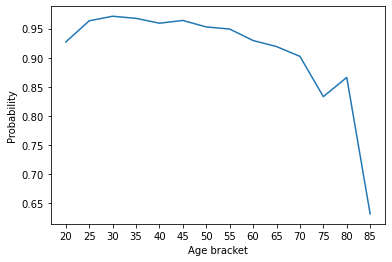

In [25]:
import matplotlib.pyplot as plt

plt.plot(agedist[:,0])
plt.xlabel('Age bracket')
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13], labels=['20','25','30','35','40','45','50','55','60','65','70','75','80','85'])
plt.ylabel('Probability')
plt.show()

The pattern shows slightly younger customers with the highest probability of buying insurance.  This could be specific to this particular region and sales channel.  The highest response rate for all customers was a slightly older age bracket.

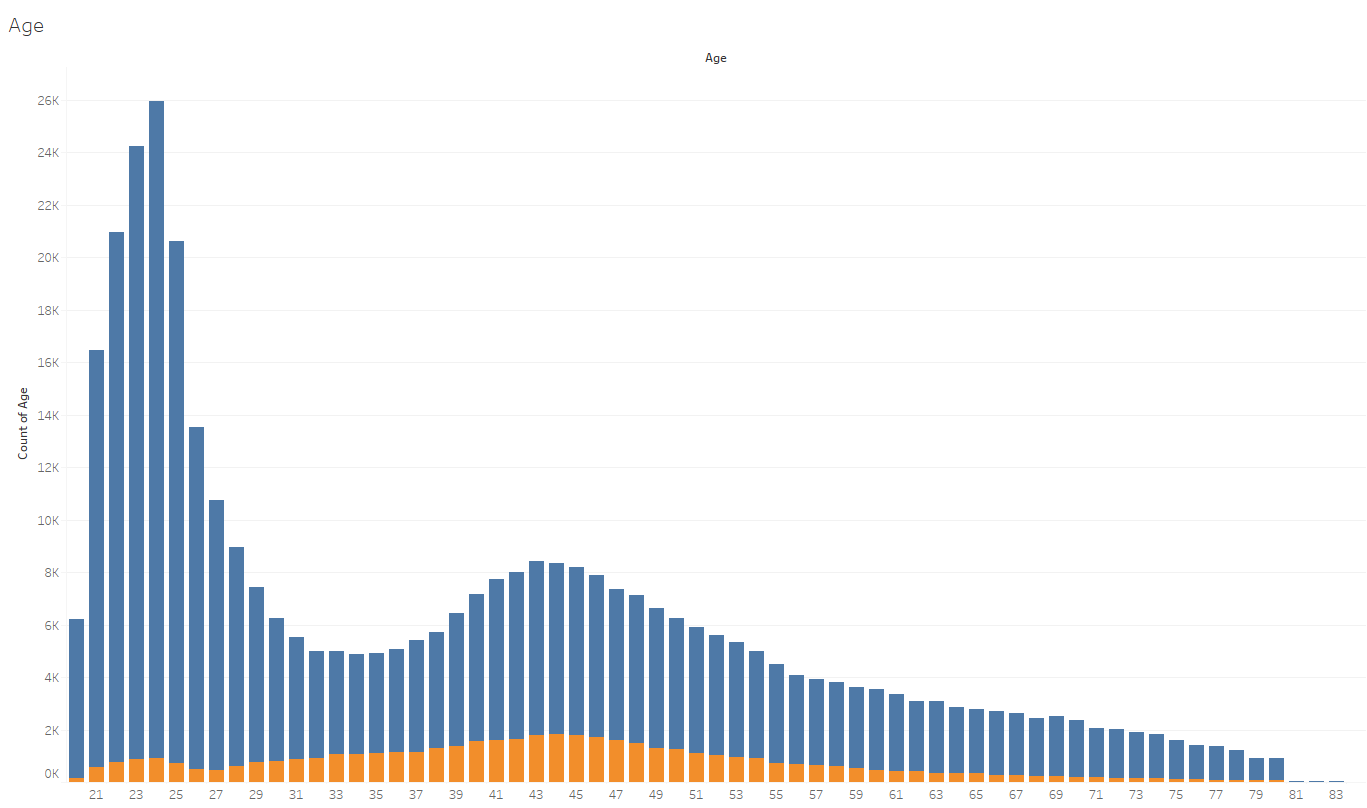

In [26]:
model.predict(exampledf)

array([[0.9270532 , 0.07294679],
       [0.96349573, 0.03650431],
       [0.97132325, 0.02867679],
       [0.96771103, 0.03228899],
       [0.9593174 , 0.04068264],
       [0.9641173 , 0.03588269],
       [0.9529215 , 0.04707853],
       [0.94928527, 0.05071468],
       [0.92957145, 0.07042857],
       [0.91915375, 0.08084622],
       [0.90231884, 0.09768119],
       [0.8329854 , 0.16701461],
       [0.86610556, 0.13389452],
       [0.6312939 , 0.36870614]], dtype=float32)

In [27]:
exampledf.loc[:,'Gender_1'] = 0
exampledf.loc[:,'Driving_License_1'] = 0
exampledf.loc[:,'Vehicle_Damage_Yes'] = 1
exampledf.loc[:,'Previously_Insured_1'] = 0
exampledf.loc[:,'Vehicle_Age_< 1 Year'] = 0
exampledf.loc[:,'Vehicle_Age_> 2 Years'] = 0

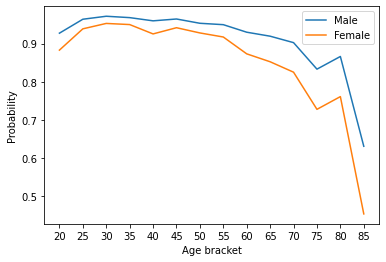

In [28]:
agedistf = model.predict(exampledf)
plt.plot(agedist[:,0])
plt.plot(agedistf[:,0])
plt.xlabel('Age bracket')
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13], labels=['20','25','30','35','40','45','50','55','60','65','70','75','80','85'])
plt.ylabel('Probability')
plt.legend(['Male','Female'])
plt.show()

Females have slightly lower probability of buying vehicle insurance, as evident by Tableau visual.

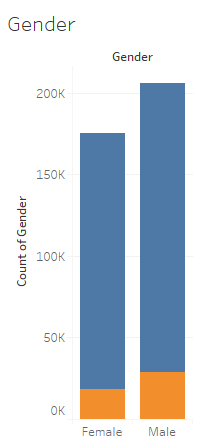

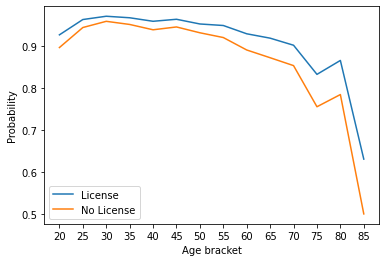

In [30]:
# No Driver License
exampledf.loc[:,'Gender_1'] = 1
exampledf.loc[:,'Driving_License_1'] = 0
exampledf.loc[:,'Vehicle_Damage_Yes'] = 1
exampledf.loc[:,'Previously_Insured_1'] = 0
exampledf.loc[:,'Vehicle_Age_< 1 Year'] = 0
exampledf.loc[:,'Vehicle_Age_> 2 Years'] = 0

agedistnoDL = model.predict(exampledf)
plt.plot(agedist[:,0])
plt.plot(agedistnoDL[:,0])
plt.xlabel('Age bracket')
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13], labels=['20','25','30','35','40','45','50','55','60','65','70','75','80','85'])
plt.ylabel('Probability')
plt.legend(['License','No License'])
plt.show()

Lack of driving license reduces probability slightly- consistent with observation in Tableau

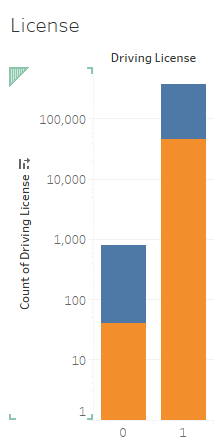

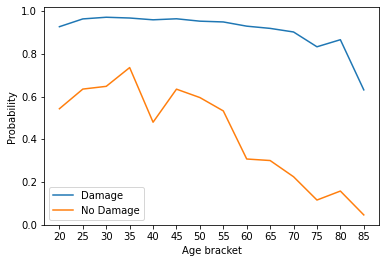

In [31]:
#No Vehicle Damage
exampledf.loc[:,'Gender_1'] = 1
exampledf.loc[:,'Driving_License_1'] = 1
exampledf.loc[:,'Vehicle_Damage_Yes'] = 0
exampledf.loc[:,'Previously_Insured_1'] = 0
exampledf.loc[:,'Vehicle_Age_< 1 Year'] = 0
exampledf.loc[:,'Vehicle_Age_> 2 Years'] = 0

agedistb = model.predict(exampledf)
plt.plot(agedist[:,0])
plt.plot(agedistb[:,0])
plt.xlabel('Age bracket')
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13], labels=['20','25','30','35','40','45','50','55','60','65','70','75','80','85'])
plt.ylabel('Probability')
plt.legend(['Damage','No Damage'])
plt.show()

No vehicle damage reduces probability drastically- consistent with Tableau observations

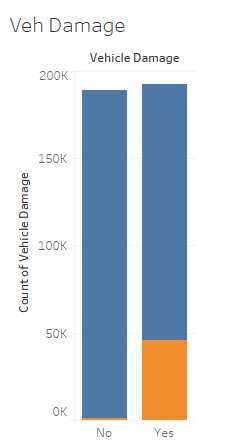


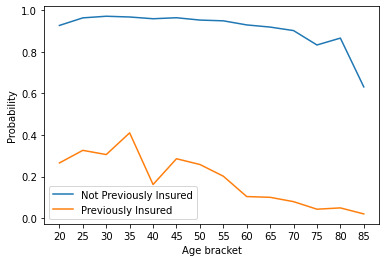

In [32]:
#Previously Insured
exampledf.loc[:,'Gender_1'] = 1
exampledf.loc[:,'Driving_License_1'] = 1
exampledf.loc[:,'Vehicle_Damage_Yes'] = 1
exampledf.loc[:,'Previously_Insured_1'] = 1
exampledf.loc[:,'Vehicle_Age_< 1 Year'] = 0
exampledf.loc[:,'Vehicle_Age_> 2 Years'] = 0

agedistb = model.predict(exampledf)
plt.plot(agedist[:,0])
plt.plot(agedistb[:,0])
plt.xlabel('Age bracket')
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13], labels=['20','25','30','35','40','45','50','55','60','65','70','75','80','85'])
plt.ylabel('Probability')
plt.legend(['Not Previously Insured','Previously Insured'])
plt.show()

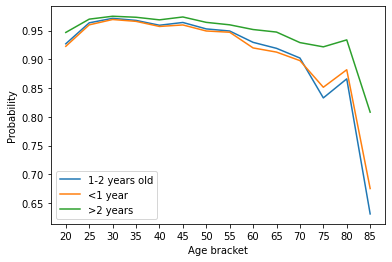

In [33]:
# Different ages of cars
exampledf.loc[:,'Gender_1'] = 1
exampledf.loc[:,'Driving_License_1'] = 1
exampledf.loc[:,'Vehicle_Damage_Yes'] = 1
exampledf.loc[:,'Previously_Insured_1'] = 0
exampledf.loc[:,'Vehicle_Age_< 1 Year'] = 1
exampledf.loc[:,'Vehicle_Age_> 2 Years'] = 0

agedistb = model.predict(exampledf)
exampledf.loc[:,'Vehicle_Age_< 1 Year'] = 0
exampledf.loc[:,'Vehicle_Age_> 2 Years'] = 1
agedistc = model.predict(exampledf)
plt.plot(agedist[:,0])
plt.plot(agedistb[:,0])
plt.plot(agedistc[:,0])
plt.xlabel('Age bracket')
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13], labels=['20','25','30','35','40','45','50','55','60','65','70','75','80','85'])
plt.ylabel('Probability')
plt.legend(['1-2 years old','<1 year','>2 years'])
plt.show()

Vehicle age makes little difference to probability.  Older cars have higher probability of owners buying insurance.  This is consistent with the Tableau visual:

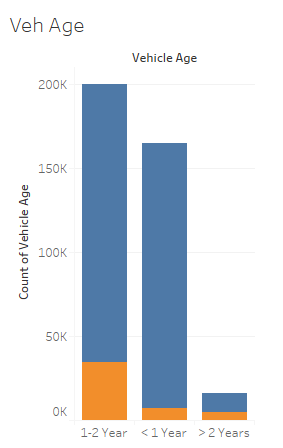

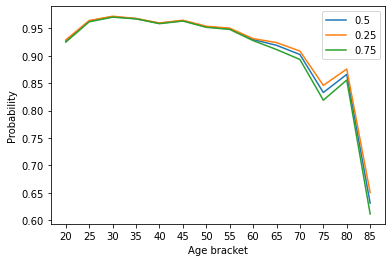

In [34]:
# Vintage
exampledf.loc[:,'Vintage'] = 0.25
exampledf.loc[:,'Gender_1'] = 1
exampledf.loc[:,'Driving_License_1'] = 1
exampledf.loc[:,'Vehicle_Damage_Yes'] = 1
exampledf.loc[:,'Previously_Insured_1'] = 0
exampledf.loc[:,'Vehicle_Age_< 1 Year'] = 0
exampledf.loc[:,'Vehicle_Age_> 2 Years'] = 0

agedistb = model.predict(exampledf)
exampledf.loc[:,'Vintage'] = 0.75
agedistc = model.predict(exampledf)
plt.plot(agedist[:,0])
plt.plot(agedistb[:,0])
plt.plot(agedistc[:,0])
plt.xlabel('Age bracket')
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13], labels=['20','25','30','35','40','45','50','55','60','65','70','75','80','85'])
plt.ylabel('Probability')
plt.legend(['0.5','0.25','0.75'])
plt.show()

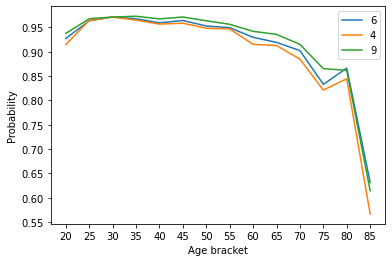

In [35]:
# Adjusting Annual Premium
exampledf.loc[:,'Annual_Premium_6.0'] = 0
exampledf.loc[:,'Annual_Premium_4.0'] = 1
exampledf.loc[:,'Gender_1'] = 1
exampledf.loc[:,'Driving_License_1'] = 1
exampledf.loc[:,'Vehicle_Damage_Yes'] = 1
exampledf.loc[:,'Previously_Insured_1'] = 0
exampledf.loc[:,'Vehicle_Age_< 1 Year'] = 0
exampledf.loc[:,'Vehicle_Age_> 2 Years'] = 0

agedistb = model.predict(exampledf)
exampledf.loc[:,'Annual_Premium_4.0'] = 0
exampledf.loc[:,'Annual_Premium_9.0'] = 1
agedistc = model.predict(exampledf)
plt.plot(agedist[:,0])
plt.plot(agedistb[:,0])
plt.plot(agedistc[:,0])
plt.xlabel('Age bracket')
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13], labels=['20','25','30','35','40','45','50','55','60','65','70','75','80','85'])
plt.ylabel('Probability')
plt.legend(['6','4','9'])
plt.show()

Vintage and annual premium have very little effect on probability, as visualized in the other notebook

# Conclusions

### The variables with the greatest effect on probability were the same as those predicted in the previous notebook, and visualized in Tableau:

* Previous vehicle insurance = 1
* Vehicle damage = 0

Almost nobody in these groups bought insurance, and the model correctly reduced probability of purchase accordingly

### Other variables had minor effects:

* Gender
* Vehicle age
* Driving license

### Other variables had apparently insignificant effects:

* Vintage
* Annual premius

Thank you for viewing and running my notebook!